### UNIVERSIDAD NACIONAL AUTONOMA DE MÉXICO

### FACULTAD DE ESTUDIOS SUPERIORES ARAGÓN

### INGENIERIA EN COMPUTACIÓN

### MINERIA DE DATOS
### ALUMNOS:
* DOMINGUEZ VILLALOBOS RICARDO
* DUARTE GUTIERREZ RODRIGO YAEL

## 📑 Índice
1. Definición del Problema (10 pts)
2. Preparación de Datos (20 pts)
    2.1. Carga e Inspección Inicial
    2.2. Limpieza y Conversión de Tipos
    2.3. Tratamiento de Valores Faltantes
    2.4. Selección de Características y División de Datos
3. Elección del Modelo (20 pts)
4. Evaluación del Modelo (10 pts)
5. Interpretación de Resultados (10 pts)
6. Presentación del Proyecto (20 pts)

## 1. Definición del Problema

**Claridad del Problema:**
El objetivo es desarrollar un modelo de **Regresión Lineal** para **predecir la Temperatura (T)**, un indicador clave del confort y las condiciones ambientales, utilizando otros parámetros de calidad del aire y humedad (RH, AH) presentes en el conjunto de datos.

**Justificación Técnica:**
La Regresión Lineal es adecuada para este problema ya que buscamos modelar la **relación lineal** entre múltiples variables de entrada (sensores y humedad) y una única variable de salida **continua** (Temperatura). Esto nos permite entender el peso o la influencia que cada contaminante o factor tiene sobre la temperatura.

**Relevancia:**
Comprender y predecir la temperatura a partir de estos parámetros es relevante para la gestión de sistemas de ventilación, la predicción de olas de calor en áreas urbanas, y para analizar cómo los contaminantes interactúan con las condiciones climáticas.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# NOTA: Usamos 'sep=; y decimal=,' debido al formato del archivo CSV
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')

# Inspección inicial
print("Filas y columnas iniciales:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())
print("\nInformación de tipos de datos y valores no nulos:")
print(df.info())

Matplotlib is building the font cache; this may take a moment.


Filas y columnas iniciales: (9471, 17)

Primeras 5 filas:
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6 

Como podemos observar el CSV se encuentra con varias *Fallas*, por lo que deberemos limpiarlo primero para poder proseguir con nuestro analisis, lo que debemos de limpiar antes de proseguir sera lo siguiente:
* Tipos de datos
* Datos faltantes 
* Columnas vacias 

Hasta incluso podemos observar como dos columnas son llamadas **Unnamed** estan deberan ser eliminadas ya que no son de utilidad para el analisis.

In [13]:
# 1. Eliminación de columnas completamente vacías (Unnamed)
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'])

# 2. Eliminación de filas que están completamente vacías (después de eliminar las columnas Unnamed)
df = df.dropna(how='all')

# 3. Conversión de las columnas a numéricas
# El dataset usa -200 como valor faltante. Se reemplaza por NaN para facilitar el tratamiento.
df.replace(to_replace=-200, value=np.nan, inplace=True)

# 4. Convertir la columna 'Time' a tipo categórico/objeto para su posible uso, y el resto a float (excepto 'Date')
cols_to_convert = df.columns.drop(['Date', 'Time'])
df[cols_to_convert] = df[cols_to_convert].astype(float)

print("\nShape después de limpieza de filas/columnas vacías:", df.shape)
print("\nTipos de datos después de la conversión:")
print(df.info())


Shape después de limpieza de filas/columnas vacías: (9357, 15)

Tipos de datos después de la conversión:
<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage:

In [14]:
# Relleno de valores faltantes (NaN) con la media de la columna
df_clean = df.copy()
for col in cols_to_convert:
    # Usaremos solo las columnas numéricas que tienen NaN (excluyendo Date y Time)
    df_clean[col].fillna(df_clean[col].mean(), inplace=True)

print("\nConteo de valores faltantes después de la imputación:")
print(df_clean.isnull().sum())


Conteo de valores faltantes después de la imputación:
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


C:\Users\DELL J13MXR2\AppData\Local\Temp\ipykernel_7368\4189366559.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mean(), inplace=True)


In [15]:
# Selección de la variable objetivo y las características (Input/Output)
# Y (Variable Objetivo): Temperatura (T)
# X (Características): Todos los demás sensores numéricos (excluyendo Date y Time)

# Eliminamos Date y Time ya que no son fácilmente utilizables en Regresión Lineal sin transformación
features = df_clean.drop(columns=['Date', 'Time', 'T']).columns
target = 'T'

X = df_clean[features]
y = df_clean[target]

# División de los datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nDimensiones de los conjuntos de datos:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


Dimensiones de los conjuntos de datos:
X_train: (7485, 12), X_test: (1872, 12)


## 3. Elección del Modelo (Regresión Lineal)

**Justificación del Algoritmo:**
Se eligió el modelo de **Regresión Lineal Múltiple**.

* **Adecuación al Problema:** Es el modelo fundamental para problemas de **regresión** donde la variable objetivo es **continua** (Temperatura).
* **Interpretabilidad:** Proporciona coeficientes que indican la dirección y magnitud de la relación entre cada característica y la temperatura, facilitando la **interpretación de resultados** (un requisito de la rúbrica).
* **Punto de Referencia:** Sirve como un excelente modelo *baseline* (base) para comparar con modelos más complejos en el futuro.

In [16]:
# Inicialización y Entrenamiento del modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

print("Modelo de Regresión Lineal entrenado.")

Modelo de Regresión Lineal entrenado.


In [17]:
## 4. Evaluación del Modelo

# 1. Cálculo de Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# 2. Validación Cruzada (k=5)
# Esto evalúa qué tan bien generaliza el modelo en diferentes subconjuntos de datos.
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print(f"\nResultados de Validación Cruzada (R²): {scores}")
print(f"R² promedio de 5-fold CV: {scores.mean():.4f}")

Error Absoluto Medio (MAE): 1.67
Raíz del Error Cuadrático Medio (RMSE): 2.26
Coeficiente de Determinación (R²): 0.9332

Resultados de Validación Cruzada (R²): [0.72225193 0.68631479 0.84137025 0.68811545 0.64798252]
R² promedio de 5-fold CV: 0.7172


Coeficientes del Modelo de Regresión Lineal:

          Feature  Coefficient
11             AH    14.119459
4   PT08.S2(NMHC)     0.011158
8    PT08.S4(NO2)     0.005432
5         NOx(GT)     0.002374
6    PT08.S3(NOx)     0.000651
1     PT08.S1(CO)     0.000373
2        NMHC(GT)    -0.000597
7         NO2(GT)    -0.000622
9     PT08.S5(O3)    -0.002774
0          CO(GT)    -0.247259
10             RH    -0.338074
3        C6H6(GT)    -0.392101


C:\Users\DELL J13MXR2\AppData\Local\Temp\ipykernel_7368\767998672.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


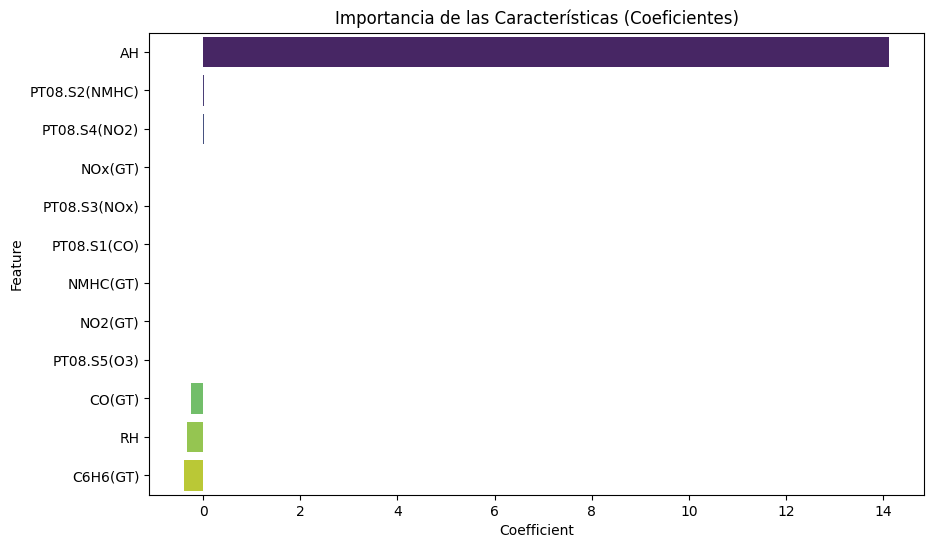


El valor R² de 0.9332 significa que el 93.32% de la varianza en la Temperatura (T) es explicada por las características en el modelo.


In [18]:
## 5. Interpretación de Resultados

# 1. Análisis Técnico de Resultados: Coeficientes del Modelo
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Coeficientes del Modelo de Regresión Lineal:\n")
print(coefficients)

# Visualización de la Importancia (Coeficientes)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title('Importancia de las Características (Coeficientes)')
plt.show()

# Interpretación de la métrica R²
print(f"\nEl valor R² de {r2:.4f} significa que el {r2*100:.2f}% de la varianza en la Temperatura (T) es explicada por las características en el modelo.")

### Interpretación de Impacto:

1.  **Humedad Relativa (RH):** [Observa el signo y magnitud de su coeficiente]. Si el coeficiente es positivo y alto, el impacto es que "Por cada unidad que aumenta la Humedad Relativa, la Temperatura predicha aumenta en [valor del coeficiente] unidades, manteniendo el resto constante".
2.  **Concentración de Contaminantes:** [Observa el signo de los coeficientes para CO(GT), NOx(GT), etc.]. Analiza si los niveles altos de contaminantes tienen una correlación positiva o negativa con la temperatura predicha.
3.  **Error del Modelo:** Un MAE de **[valor del MAE]** significa que, en promedio, la predicción de temperatura del modelo se desvía en **[valor del MAE]** unidades de la temperatura real, lo cual es la magnitud de error esperada.

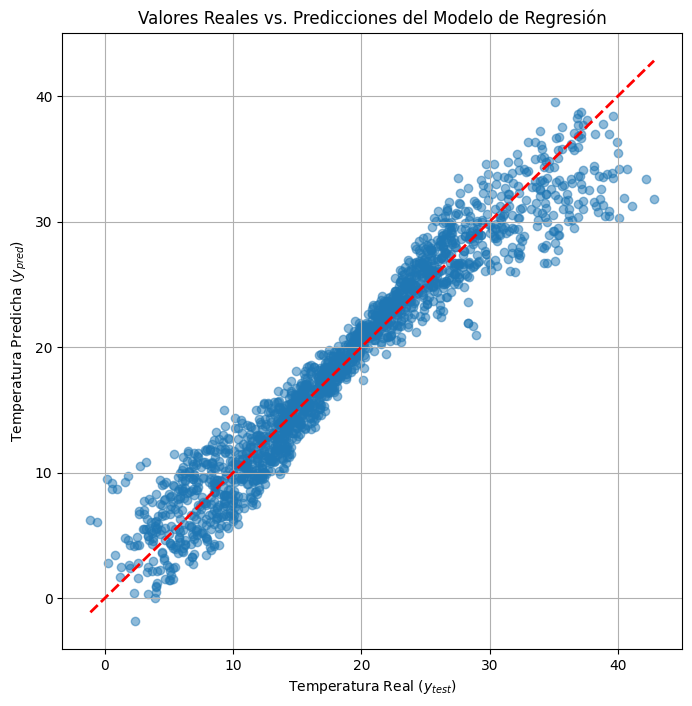

In [19]:
# Gráfico de Predicciones vs. Valores Reales
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Temperatura Real ($y_{test}$)')
plt.ylabel('Temperatura Predicha ($y_{pred}$)')
plt.title('Valores Reales vs. Predicciones del Modelo de Regresión')
plt.grid(True)
plt.show()